# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# keep matplotlib interactive
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Churn Prediction

Any subscription-based business is committed to keep their customer happy in exchange for their loyalty. Despite their efforts, some customers will eventually not renew their subscription. In this latter case, if a customer has not renewed within a time window after its subscription expiration date, this customer is said to have churned. Although each service provider offers several subscription options (monthly, yearly, basic, premium,...), the time window to consider a customer has churned varies quite a lot. It seems that each company sets their own.

This project is based on a [Kaggle competition](https://www.kaggle.com/c/kkbox-churn-prediction-challenge) where KKBOX, an Asian leading __music streaming service__, is interested in learning from their customer behavior to prevent them from churning.

The __grace period is 30 days__ in order to consider a customer has churned after its current membership ends. The goal is to determine churn from one month to the next.

In [2]:
# train.csv only contains 
train_dir = os.path.join(os.pardir, 'data', 'raw', 'train.csv')
df_train = pd.read_csv(train_dir, index_col = 'msno')

In [3]:
df_train.head()

,is_churn
msno,
waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992931 entries, waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y= to ZoVEIVMCpKT9/MJgqO+fh9xYrNM2vNisLhJ4xY/CVyk=
Data columns (total 1 columns):
is_churn    992931 non-null int64
dtypes: int64(1)
memory usage: 15.2+ MB


In [5]:
# _ , axChurn = plt.subplots(figsize=(10, 2))

# # one could histogram is_churn column directly but it doesn't look good
# # df_train.is_churn.plot(kind='hist', bins=[0, 1, 2], rwidth=0.5, align = 'left', ax=axChurn)

# # histogram via value_counts() then make bar plot, change ticks labels
# # churn_distrib = df_train.is_churn.value_counts()
# # churn_distrib.plot(kind='barh', ax=axChurn)
# # axChurn.set_yticklabels(('No Churn', 'Churn'), rotation = 0)
# ## plt.xticks(churn_distrib.index, ('No Churn', 'Churn'), rotation = 0)

<IPython.core.display.Javascript object>


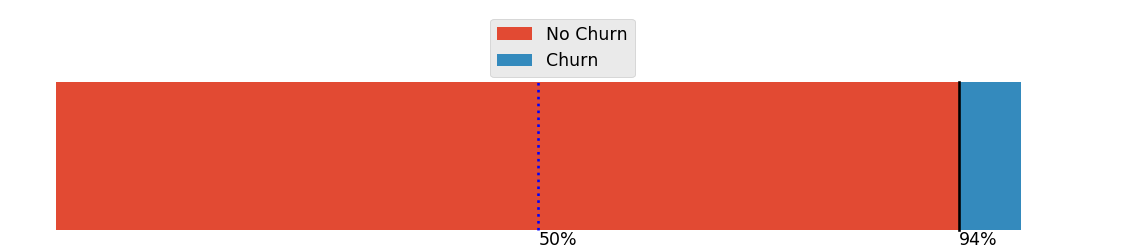

(0.0, 1.05, -0.44000000000000006, 0.44000000000000006)

In [6]:
_ , axChurn = plt.subplots(figsize=(9, 2))
axChurn.set_position([0.05, 0.05, 0.9, 0.65])
# histogram via value_counts() then change ticks labels
churn_distrib = df_train.is_churn.value_counts(normalize=True)
no_churn = churn_distrib.loc[0]
axChurn.barh(0, no_churn)
h_bar2 = axChurn.barh(0, churn_distrib.loc[1],  left = no_churn)
axChurn.legend(['No Churn', 'Churn'], bbox_to_anchor=(0.5,1.4), loc = 'upper center')
bar_height = h_bar2.patches[-1].get_height()/2
axChurn.plot([0.5]*2, [-bar_height, bar_height], color = 'b', linestyle = ':')
axChurn.text(0.5,-bar_height*1.2, '50%')
axChurn.plot([no_churn]*2, [-bar_height, bar_height], color = 'k', linestyle = '-')
axChurn.text(no_churn,-bar_height*1.2, '{:.0f}%'.format(no_churn*100))
axChurn.axis('off')

# Data Description
There 3 data files that can tell us about customer behavior.

                                                

|                                       transactions.csv                                        |
|-----------------------------------------------------------------------------------------------|
| msno                   | user id  (letters, digits and special characters)                    |
| payment_method_id      | payment method   (masked)                                            |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          | true when customer opted in renewing its subscription automatically  |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |



|              user_logs.csv                                              |
|-------------------------------------------------------------------------|
| msno       | user id  (letters, digits and special characters)          |
| date       | format %Y%m%d                                              |
| num_25     | # of songs played less than 25% of the song length         |
| num_50     | # of songs played between 25% to 50% of the song length    |
| num_75     | # of songs played between 50% to 75% of of the song length |
| num_985    | # of songs played between 75% to 98.5% of the song length  |
| num_100    | # of songs played over 98.5% of the song length            |
| num_unq    | # of unique songs played                                   |
| total_secs | total seconds played                                       |

|                                    members.csv                  |
|---------------------------------|-------------------------------|
| msno                            |user id  (letters, digits and special characters) |
| city                            |          name of city         |
| bd                              | age$^i$                       |
| gender                          |            gender             |
| registered_via                  |     registration method       |
| registration_init_time          |          format %Y%m%d        |
| expiration_date                 | format %Y%m%d $^{ii}$         |

$^i$Note: this column has outlier values ranging from -7000 to 2015 please use your judgement.

$^{ii}$Note: taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

### Transactions

In [7]:
transaction_dir = os.path.join(os.pardir, 'data', 'raw', 'transactions.csv')
df_transac = pd.read_csv(transaction_dir, index_col = 'msno', parse_dates=['transaction_date', 'membership_expire_date'])

In [8]:
df_transac.count()

payment_method_id         21547746
payment_plan_days         21547746
plan_list_price           21547746
actual_amount_paid        21547746
is_auto_renew             21547746
transaction_date          21547746
membership_expire_date    21547746
is_cancel                 21547746
dtype: int64

In [9]:
# treat payment_method_id as a category
df_transac.payment_method_id = df_transac.payment_method_id.astype('category')
# convert relevant columns to boolean
df_transac.is_auto_renew = df_transac.is_auto_renew.astype(bool)
df_transac.is_cancel = df_transac.is_cancel.astype(bool)

In [10]:
df_transac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21547746 entries, YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc= to oE4y2wK5E7OR8zyrCHeW02uTeI6wTwT4QTApEVBNEdM=
Data columns (total 8 columns):
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             bool
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                 bool
dtypes: bool(2), category(1), datetime64[ns](2), int64(3)
memory usage: 1.0+ GB


In [11]:
def plot_bar(df, bar_list, is_Norm=True):
    """
        Make a bar plot using dataframe df and associated columns in bar_list
        is_Norm will normalize distribution by counts
        df: pandas DataFrame
        bar_list: list of column names
    """
    subrows = int(np.ceil(len(bar_list) / 2))
    discard_last_ax = bool(len(bar_list) % 2)
    # special case when there is only one column specified
    if subrows == 1 and discard_last_ax:
        _ , ax = plt.subplots(figsize=(9,5))
        ax = [ax]
    else:
        _ , ax = plt.subplots(subrows, 2)
        ax = ax.flatten()
    for k, colname in enumerate(bar_list):
        
        # select column and make bar plot
        dis = df[colname]
        (dis.value_counts(normalize = is_Norm).sort_index()*100).plot(kind='bar', ax=ax[k], color='b')
        
        # add title
        ax[k].set_title(dis.name + ' Distribution')
        
        # add percent character to y tick label if plot normalized
        if is_Norm:
            # add percent on y axis labels, uses numerical value of each tick (just in case scale has changed)
            ax[k].set_yticklabels([ '{:.0f}%'.format(l)  for l in ax[k].get_yticks()])
        
        # set x ticklabels to integer, reformat existing labels (categories must be treated as string here)
#         ax[k].set_xticklabels([ '{:.0f}'.format(float(l.get_text()))  for l in ax[k].get_xticklabels()])
        
        # reset x axis label to 45 rotation
        ax[k].tick_params(axis = 'x', rotation = 45)
        
    # decide to keep last axes
    if discard_last_ax and subrows > 1: ax[-1].set_visible(False)
    plt.tight_layout()

<IPython.core.display.Javascript object>


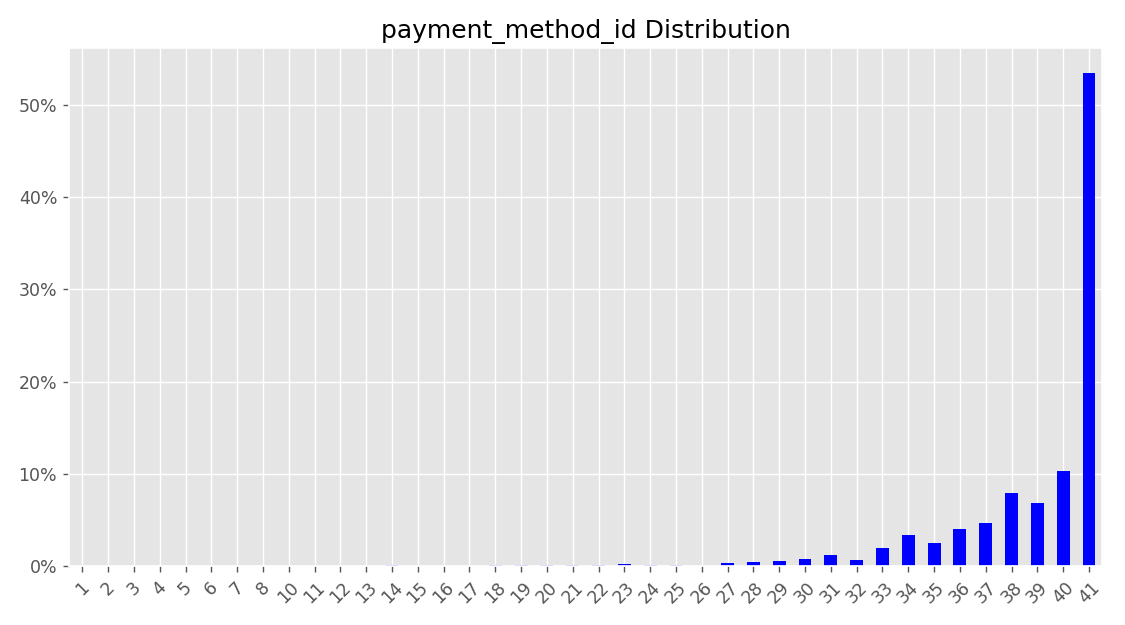

In [12]:
plot_bar(df_transac, ['payment_method_id'])

<IPython.core.display.Javascript object>


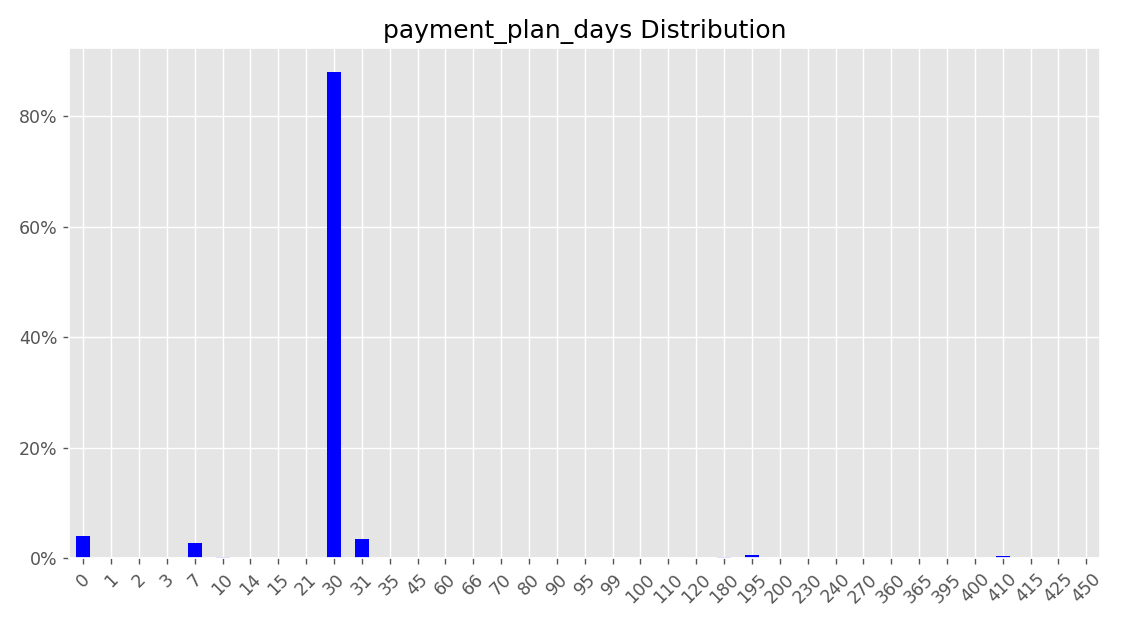

In [13]:
# Number of days per plan
plot_bar(df_transac, ['payment_plan_days'])

<IPython.core.display.Javascript object>


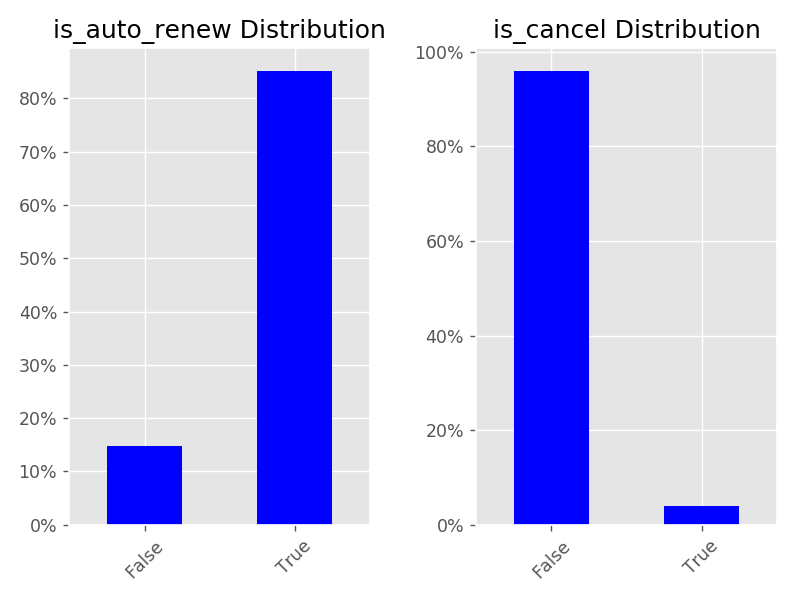

In [14]:
plot_bar(df_transac, ['is_auto_renew' , 'is_cancel'])

In [15]:
df_transac.describe()

,payment_plan_days,plan_list_price,actual_amount_paid
count,2.154775e+07,2.154775e+07,2.154775e+07
mean,3.133906e+01,1.398850e+02,1.419873e+02
std,3.035649e+01,1.309647e+02,1.324824e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+01,9.900000e+01,9.900000e+01
50%,3.000000e+01,1.490000e+02,1.490000e+02
75%,3.000000e+01,1.490000e+02,1.490000e+02
max,4.500000e+02,2.000000e+03,2.000000e+03


<IPython.core.display.Javascript object>


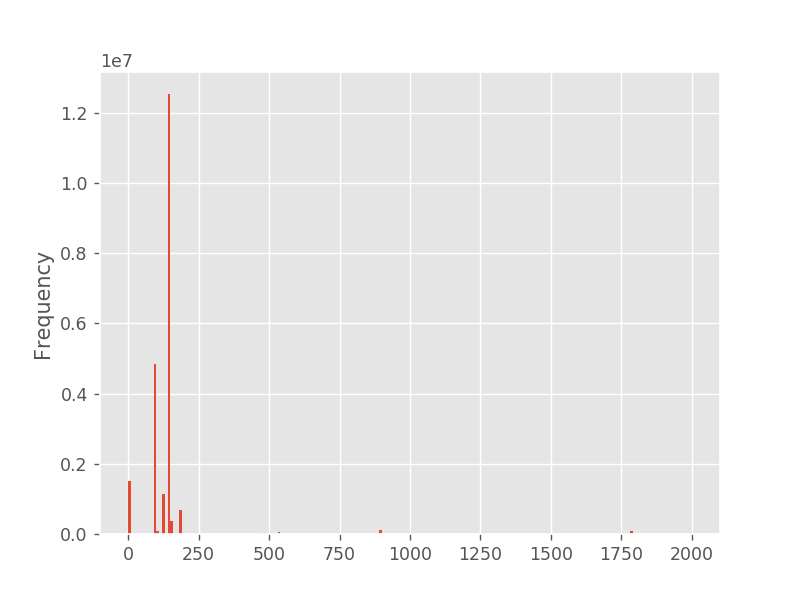

In [16]:
_ , axListPrice = plt.subplots()
df_transac.plan_list_price.plot(kind = 'hist', bins = 200, ax = axListPrice)

In [17]:
# percent difference between plan price and price actually paid
discount_percent = 1 - (df_transac.actual_amount_paid/df_transac.plan_list_price)

<IPython.core.display.Javascript object>


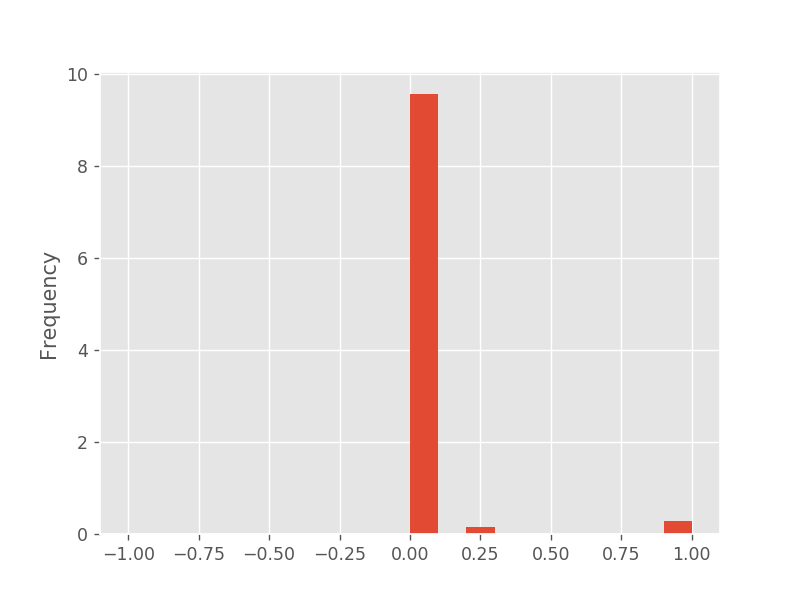

In [18]:
_ , axDiscount = plt.subplots()
discount_percent.plot(kind = 'hist', range = (-1, 1), bins = 20, ax = axDiscount, density = True)

<IPython.core.display.Javascript object>


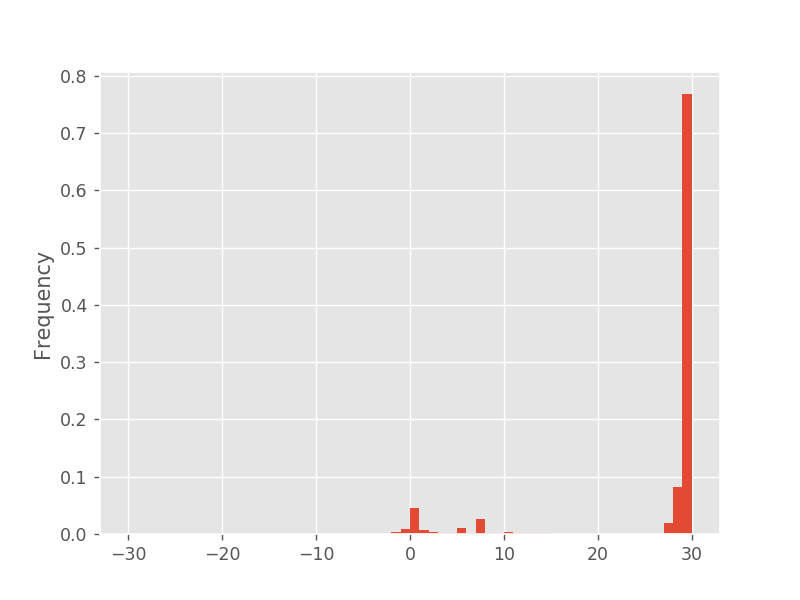

In [19]:
# compute difference in time between expiration date and transaction date
deltaTransacDate = df_transac.membership_expire_date - df_transac.transaction_date

# convert timedelta object to days (result cast to int)
deltaTransacDate = deltaTransacDate.astype('timedelta64[D]')
# convert timedelta object to days (keep decimals)
# deltaTransacDate = deltaTransacDate/pd.Timedelta('1 day')
# deltaTransacDate = deltaTransacDate/np.timedelta64(1, 'D')

# histogram days
_ , axTransacDate = plt.subplots()
deltaTransacDate.plot(kind = 'hist', range= (-30, 30), bins = 60, normed = True, ax = axTransacDate)

# NOTE: some unrealistic out of range values like -17599

In [ ]:
# add is_churn to df_transac by merging
df_transac.join(df_train)
pd.merge(df_transac, df_train, how='inner', on = 'msno')

In [ ]:
ax5 = sns.violinplot(x="payment_plan_days", y="plan_list_price", data=df_transac)

### User_log

In [ ]:
user_log_dir = os.path.join(os.pardir, 'data', 'raw', 'user_logs.csv')
Num_rows = int(20e6)
reader_iter = pd.read_csv(user_log_dir, index_col = 'msno', parse_dates=['date'], chunksize=Num_rows,\
        usecols = [ 'num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

In [ ]:
df_chunk = reader_iter.get_chunk(Num_rows)
# histogram all columns separately
hist_num = np.apply_along_axis(lambda a: np.histogram(a, bins=bin_edges)[0], 0, df_chunk)

In [ ]:
# compile bin edges to histogram
Nbin = 1000
bin_edges = np.linspace( 0, Nbin, num=Nbin+1)
hist_num_tot = np.array(np.zeros((Nbin,5)))

for df_chunk in reader_iter:
    
    # histogram all log for num_x
#     dfhistoNum = df_chunk.drop(labels='msno', axis=1)
    hist_num = np.apply_along_axis(lambda a: np.histogram(a, bins=bin_edges)[0], 0, dfhistoNum)
    hist_num_tot = hist_num_tot + hist_num